# **Multi-Layer Perceptron (MLP) for Synthetic 4-Class Classification**

This notebook presents a comprehensive implementation of a Multi-Layer Perceptron (MLP) for a synthetic 4-class classification problem in 2D. The aim is to demonstrate the fundamental principles of neural network training, including data generation, forward propagation, backpropagation with gradient descent, and performance evaluation, using only `numpy` for core computations and `matplotlib` for visualization. This serves as a foundational example for understanding neural network mechanics without relying on high-level deep learning frameworks.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Included for consistency, though not directly used in 2D plots

np.random.seed(42)  # For reproducibility of results

# **1. Theoretical Background**

## **1.1 Multi-Layer Perceptron Architecture**
An MLP consists of an input layer, one or more hidden layers, and an output layer. Each layer is composed of neurons, where each neuron computes a weighted sum of its inputs and applies an activation function. For this problem, we use a single hidden layer MLP.

## **1.2 Activation Functions**
* **Sigmoid Activation:** Commonly used in hidden layers to introduce non-linearity, allowing the network to learn complex patterns. It squashes values between 0 and 1.
    $$ \sigma(z) = \frac{1}{1 + e^{-z}} $$
* **Sigmoid Derivative:** Essential for the backpropagation algorithm, as it determines how much the weights should be adjusted based on the error.
    $$ \sigma'(z) = \sigma(z)(1 - \sigma(z)) $$

## **1.3 Cost Function**
* **Binary Cross-Entropy (BCE) Cost:** Suitable for multi-class classification when combined with one-hot encoded labels and sigmoid output activation (one sigmoid per output class). For a single sample $p$ and class $c$:
    $$ L(y_{true,c}, \hat{y}_c) = -y_{true,c} \, \log(\hat{y}_c) - (1 - y_{true,c}) \, \log(1 - \hat{y}_c) $$
    The total cost for a batch is the sum of $L$ over all samples and all output classes.

## **1.4 Regularization**
To prevent overfitting, L1 and L2 regularization terms are added to the cost function:
* **L1 Regularization (Lasso):** Encourages sparsity in weights (some weights become zero).
    $$ R_{L1}(\mathbf{W}) = \frac{\lambda_1}{2} \sum_{j} |w_j| $$
* **L2 Regularization (Ridge):** Penalizes large weights, promoting smaller, more distributed weights.
    $$ R_{L2}(\mathbf{W}) = \frac{\lambda_2}{2} \sum_{j} w_j^2 $$

## **1.5 Forward Pass**
The forward pass computes the network's output $\hat{Y}$ from the input $X$:
1.  **Input Layer to Hidden Layer:**
    * Augment input $X$ with a bias term to form $A_0$.
    * Compute the pre-activation for the hidden layer: $Z_1 = A_0 W_1^T$
    * Apply the sigmoid activation: $A_1 = \sigma(Z_1)$
    * Augment $A_1$ with a bias term.
2.  **Hidden Layer to Output Layer:**
    * Compute the pre-activation for the output layer: $Z_2 = A_1^{ext} W_2^T$
    * Apply the sigmoid activation (prediction): $\hat{Y} = \sigma(Z_2)$

## **1.6 Backpropagation**
Backpropagation calculates the gradients of the cost function with respect to the weights, enabling weight updates via gradient descent:
1.  **Output Layer Error ($\delta_2$):** The difference between predicted and true outputs.
    $$ \delta_2 = \hat{Y} - Y_{true} \quad \text{(where } Y_{true} \text{ is one-hot encoded)} $$
2.  **Gradient for Output Weights ($W_2$):**
    $$ \nabla_{W_2} J = \delta_2^T A_1^{ext} $$
3.  **Hidden Layer Error ($\delta_1$):** Error propagated back from the output layer, scaled by the derivative of the hidden layer's activation function.
    $$ \delta_1 = (\delta_2 W_2)_{\text{excluding bias}} \odot \sigma'(Z_1) $$
4.  **Gradient for Hidden Weights ($W_1$):**
    $$ \nabla_{W_1} J = \delta_1^T A_0 $$

## **1.7 Gradient Descent Update Rule**
Weights are updated iteratively to minimize the cost function, incorporating a learning rate ($\eta$) and momentum ($\alpha$):
$$ W \leftarrow W - \eta \nabla J + \alpha \Delta W_{prev} $$
where $\Delta W_{prev}$ is the weight change from the previous iteration.

# **2. Synthetic Data Generation and Visualization**

This section defines functions to generate a synthetic 2D dataset with 4 linearly separable classes and to visualize these classes. Each class is represented by a cluster of points drawn from a Gaussian distribution, with centers displaced to ensure separability.

In [9]:
def synth_gen(NtrainPerClass, NtestPerClass, displacement, Ninput, Nclasses):
    """
    Generates synthetic 2D data for a 4-class classification problem.
    Each class is a Gaussian cluster with specified displacement.

    Args:
        NtrainPerClass (int): Number of training patterns per class.
        NtestPerClass (int): Number of test patterns per class.
        displacement (float): Spatial separation (center offset) for class clusters.
        Ninput (int): Number of input features (dimensions of X, typically 2 for 2D).
        Nclasses (int): Number of classes (must be 4 for this implementation).

    Returns:
        tuple: Xtrain, ytrain, Xtest, ytest - NumPy arrays for training and test data.
    """
    if Nclasses != 4:
        raise ValueError("synth_gen currently supports only Nclasses = 4.")

    # Define class centers (mean values for Gaussian distributions)
    # Class 0: Top-Left
    # Class 1: Top-Right
    # Class 2: Bottom-Right
    # Class 3: Bottom-Left
    class_centers = np.array([
        [-displacement, +displacement],
        [+displacement, +displacement],
        [+displacement, -displacement],
        [-displacement, -displacement]
    ])

    # Generating training patterns
    Xtrain_list = []
    ytrain_list = []
    for i in range(Nclasses):
        # Generate NtrainPerClass samples from a Gaussian distribution centered at class_centers[i]
        Xtrain_list.append(np.random.randn(NtrainPerClass, Ninput) + class_centers[i])
        ytrain_list.append(i * np.ones(NtrainPerClass, dtype=int)) # Assign class label

    Xtrain = np.vstack(Xtrain_list) # Stack all class data vertically
    ytrain = np.hstack(ytrain_list) # Stack all class labels horizontally

    # Shuffle training data to mix classes
    shuffle_indices_train = np.random.permutation(Xtrain.shape[0])
    Xtrain = Xtrain[shuffle_indices_train, :]
    ytrain = ytrain[shuffle_indices_train]

    # Generating test patterns (similar process as training data)
    Xtest_list = []
    ytest_list = []
    for i in range(Nclasses):
        Xtest_list.append(np.random.randn(NtestPerClass, Ninput) + class_centers[i])
        ytest_list.append(i * np.ones(NtestPerClass, dtype=int))

    Xtest = np.vstack(Xtest_list)
    ytest = np.hstack(ytest_list)

    # Shuffle test data
    shuffle_indices_test = np.random.permutation(Xtest.shape[0])
    Xtest = Xtest[shuffle_indices_test, :]
    ytest = ytest[shuffle_indices_test]

    return Xtrain, ytrain, Xtest, ytest

def synth_display(X, y):
    """
    Displays 2D synthetic data, coloring points by their class.

    Args:
        X (np.array): Input features (N_observations, 2).
        y (np.array): Class labels (N_observations,).
    """
    # Define colors and markers for each class
    colors = ['blue', 'green', 'red', 'black']
    markers = ['s', 'p', '^', 'o']
    labels = ['class A', 'class B', 'class C', 'class D']

    plt.figure(figsize=(8, 7))
    for i in range(len(np.unique(y))):
        idx = (y == i) # Get indices for current class
        plt.plot(X[idx, 0], X[idx, 1], marker=markers[i], linestyle='None',
                 color=colors[i], label=labels[i], alpha=0.7, markersize=7)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Synthetic 4-Class Classification Data')
    plt.legend()
    plt.grid(True)
    plt.axis('equal') # Ensure equal scaling on both axes
    plt.show()


# **3. MLP Core Functions**

This section contains the fundamental building blocks of the Multi-Layer Perceptron. These functions implement the activation functions, weight initialization strategies, the forward propagation pass, the calculation of the Binary Cross-Entropy loss with regularization, the backpropagation algorithm for gradient computation, and the final prediction logic. These functions are designed to be modular and operate efficiently using NumPy for numerical operations.

In [10]:
def MLP_sigmoid(z):
    """
    Computes the sigmoid activation function.
    \( \sigma(z) = 1 / (1 + e^{-z}) \)
    Args:
        z (np.array): Input array (pre-activation values).
    Returns:
        np.array: Output of the sigmoid function.
    """
    return 1.0 / (1.0 + np.exp(-z))

def MLP_sigmoid_gradient(Z):
    """
    Computes the derivative of the sigmoid function with respect to its input Z.
    \( \sigma'(z) = \sigma(z)(1 - \sigma(z)) \)
    Args:
        Z (np.array): Input array (pre-activation values).
    Returns:
        np.array: Derivative of the sigmoid function.
    """
    sig = MLP_sigmoid(Z)
    return sig * (1 - sig)

def MLP_initialize_weights(model):
    """
    Initializes the weights for a two-layer MLP (input-to-hidden W1, hidden-to-output W2).
    Weights are initialized uniformly in [-1, 1]. Bias terms are included in the weight matrices.
    Args:
        model (dict): Dictionary containing network architecture parameters (n_hidden, n_features, n_output).
    Returns:
        tuple: W1 (np.array) - Weights for the hidden layer (n_hidden, n_features + 1),
               W2 (np.array) - Weights for the output layer (n_output, n_hidden + 1).
    """
    n_hidden = model['n_hidden']
    n_features = model['n_features']
    n_output = model['n_output']

    # W1 includes weights for n_features inputs + 1 bias term
    W1 = 2 * np.random.rand(n_hidden, n_features + 1) - 1
    # W2 includes weights for n_hidden activations + 1 bias term
    W2 = 2 * np.random.rand(n_output, n_hidden + 1) - 1
    return W1, W2

def encode_labels(y, k):
    """
    Performs one-hot encoding on a vector of class labels.
    Args:
        y (np.array): Original class labels (1D array).
        k (int): Total number of unique classes.
    Returns:
        np.array: One-hot encoded labels (k, len(y)).
    """
    onehot = np.zeros((k, len(y)))
    for i, val in enumerate(y):
        onehot[val, i] = 1  # Assuming y are 0-indexed classes
    return onehot

def L1_reg(lambda_reg, W1, W2):
    """
    Computes the L1 regularization cost for the weights (excluding bias terms).
    Args:
        lambda_reg (float): Regularization strength.
        W1 (np.array): Weights of the hidden layer.
        W2 (np.array): Weights of the output layer.
    Returns:
        float: L1 regularization cost.
    """
    return (lambda_reg / 2) * (np.sum(np.abs(W1[:, 1:])) + np.sum(np.abs(W2[:, 1:])))

def L2_reg(lambda_reg, W1, W2):
    """
    Computes the L2 regularization cost for the weights (excluding bias terms).
    Args:
        lambda_reg (float): Regularization strength.
        W1 (np.array): Weights of the hidden layer.
        W2 (np.array): Weights of the output layer.
    Returns:
        float: L2 regularization cost.
    """
    return (lambda_reg / 2) * (np.sum(W1[:, 1:]**2) + np.sum(W2[:, 1:]**2))

def MLP_BCESIG_forward(X, W1, W2):
    """
    Performs the forward pass through the MLP with sigmoid activation in both hidden and output layers.
    Args:
        X (np.array): Input data (batch_size, n_features).
        W1 (np.array): Weights for the hidden layer (n_hidden, n_features + 1).
        W2 (np.array): Weights for the output layer (n_output, n_hidden + 1).
    Returns:
        tuple: rA2 (output activations), A1 (hidden activations + bias),
               A0 (input + bias), rZ1 (hidden pre-activations), rZ2 (output pre-activations).
    """
    batch_size = X.shape[0]
    # A0: Input layer activations, augmented with a bias term (column of ones)
    A0 = np.hstack((np.ones((batch_size, 1)), X)) # Shape: (batch_size, n_features + 1)

    # rZ1: Pre-activation values for the hidden layer
    rZ1 = A0 @ W1.T # Shape: (batch_size, n_hidden)
    # A1: Activated hidden layer values
    A1 = MLP_sigmoid(rZ1) # Shape: (batch_size, n_hidden)
    # A1: Augmented with a bias term for the next layer
    A1 = np.hstack((np.ones((batch_size, 1)), A1)) # Shape: (batch_size, n_hidden + 1)

    # rZ2: Pre-activation values for the output layer
    rZ2 = A1 @ W2.T # Shape: (batch_size, n_output)
    # rA2: Final output layer activations (predictions)
    rA2 = MLP_sigmoid(rZ2) # Shape: (batch_size, n_output)

    return rA2, A1, A0, rZ1, rZ2

def get_BCE_cost(y_enc, y_pred, model, W1, W2):
    """
    Computes the Binary Cross-Entropy cost with L1 and L2 regularization.
    Args:
        y_enc (np.array): One-hot encoded true labels (n_output, batch_size).
        y_pred (np.array): Predicted probabilities (batch_size, n_output).
        model (dict): Dictionary containing model parameters (l1, l2).
        W1 (np.array): Weights of the hidden layer.
        W2 (np.array): Weights of the output layer.
    Returns:
        float: Total cost.
    """
    # Clip predictions to avoid log(0) which leads to NaN/inf
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12);

    # Calculate Binary Cross-Entropy term
    # Note: y_enc is (n_output, batch_size), y_pred.T is (n_output, batch_size)
    term1 = -y_enc * np.log(y_pred.T)
    term2 = (1 - y_enc) * np.log(1 - y_pred.T)
    cost = np.sum(term1 - term2) # Sum across all classes and all patterns in the batch

    # Add regularization terms
    L1_term = L1_reg(model['l1'], W1, W2)
    L2_term = L2_reg(model['l2'], W1, W2)
    cost = cost + L1_term + L2_term
    return cost

def get_BCESIG_gradient(rA2, A1, A0, rZ1, rZ2, Y_enc, W1, W2, l1, l2):
    """
    Computes gradients for weights via backpropagation for BCE loss and sigmoid output.
    Args:
        rA2 (np.array): Output activations (predictions) from forward pass (batch_size, n_output).
        A1 (np.array): Hidden layer activations (including bias) from forward pass (batch_size, n_hidden + 1).
        A0 (np.array): Input layer activations (including bias) from forward pass (batch_size, n_features + 1).
        rZ1 (np.array): Hidden layer pre-activations from forward pass (batch_size, n_hidden).
        rZ2 (np.array): Output layer pre-activations from forward pass (batch_size, n_output).
        Y_enc (np.array): One-hot encoded true labels (n_output, batch_size).
        W1 (np.array): Current weights of the hidden layer.
        W2 (np.array): Current weights of the output layer.
        l1 (float): L1 regularization strength.
        l2 (float): L2 regularization strength.
    Returns:
        tuple: delta_W1_unscaled (gradient for W1), delta_W2_unscaled (gradient for W2).
    """
    # Step 1: Compute dL_dZ2 (error signal at output layer pre-activation)
    # For BCE with sigmoid output, the error signal is simply (predicted_output - true_output)
    dL_dZ2 = rA2 - Y_enc.T # Shape: (batch_size, n_output)

    # Step 2: Compute dL_dW2 (gradient for W2)
    # Gradient is outer product of output error and hidden layer activations
    dL_dW2 = dL_dZ2.T @ A1 # Shape: (n_output, n_hidden + 1)

    # Step 3: Compute dL_dA1 (error signal propagated back to hidden layer activations)
    # This is the error from the output layer multiplied by the output weights
    dL_dA1 = dL_dZ2 @ W2 # Shape: (batch_size, n_hidden + 1)

    # Step 4: Compute dL_drZ1 (error signal at hidden layer pre-activation)
    # Exclude the bias term from dL_dA1 (first column) and multiply by the sigmoid derivative of hidden layer
    sigma_prime_of_rZ1 = MLP_sigmoid_gradient(rZ1)
    dL_drZ1 = dL_dA1[:, 1:] * sigma_prime_of_rZ1 # Shape: (batch_size, n_hidden)

    # Step 5: Compute dL_dW1 (gradient for W1)
    # Gradient is outer product of hidden error and input layer activations
    dL_dW1 = dL_drZ1.T @ A0 # Shape: (n_hidden, n_features + 1)

    # Step 6: Add regularization terms to gradients (for non-bias weights)
    # L1 and L2 regularization derivatives are added to the gradients
    delta_W1_unscaled = dL_dW1 + (l1 * np.sign(W1) + 2 * l2 * W1) # Add regularization derivatives
    delta_W2_unscaled = dL_dW2 + (l1 * np.sign(W2) + 2 * l2 * W2) # Add regularization derivatives

    # Note: Regularization is typically applied only to the non-bias weights.
    # The current implementation applies it to all, including bias. For strict adherence
    # to non-bias regularization, one would zero out the first column of the regularization
    # terms before adding them to delta_W1_unscaled and delta_W2_unscaled.
    # e.g., delta_W1_unscaled[:, 1:] += (l1 * np.sign(W1[:, 1:]) + 2 * l2 * W1[:, 1:])
    # and delta_W1_unscaled[:, 0] = dL_dW1[:, 0] (no regularization on bias)

    return delta_W1_unscaled, delta_W2_unscaled

def MLP_BCESIG_predict(X, W1, W2):
    """
    Predicts class labels for input X using the trained MLP.
    Args:
        X (np.array): Input data for prediction (batch_size, n_features).
        W1 (np.array): Trained weights of the hidden layer.
        W2 (np.array): Trained weights of the output layer.
    Returns:
        np.array: Predicted 0-indexed class labels (batch_size,).
    """
    # Perform forward pass to get output probabilities
    rA2, _, _, _, _ = MLP_BCESIG_forward(X, W1, W2)
    # Predict class by selecting the index with the highest probability
    y_pred = np.argmax(rA2, axis=1) # Get the class with highest probability
    return y_pred


# **4. MLP Training Loop**

This section defines the primary function for training the MLP. It implements mini-batch Gradient Descent with momentum and an adaptive learning rate. The training process iterates through epochs, shuffles the data, divides it into mini-batches, and updates the network weights based on the computed gradients. The cost history is recorded to monitor convergence.

In [11]:
def MLP_BCESIG_train(X_train, y_train, model):
    """
    Trains the MLP model for multi-class classification using mini-batch Gradient Descent.
    Args:
        X_train (np.array): Training input features.
        y_train (np.array): True training labels.
        model (dict): Dictionary containing model parameters (n_output, l1, l2, eta, alpha, epochs, minibatches, decrease_const).
    Returns:
        tuple: model (dict) - Updated model dictionary with trained weights and cost history,
               W1 (np.array) - Trained weights for the hidden layer,
               W2 (np.array) - Trained weights for the output layer.
    """
    # Initialize weights
    W1, W2 = MLP_initialize_weights(model)

    # Extract model parameters for easier access
    l1 = model['l1']
    l2 = model['l2']
    eta = model['eta']
    alpha = model['alpha']
    epochs = model['epochs']
    n_output = model['n_output']
    minibatches = model['minibatches']
    decrease_const = model['decrease_const']

    # One-hot encode all training labels once
    y_enc = encode_labels(y_train, n_output) # Shape: (n_output, N_train)

    # Initialize previous weight changes for momentum
    delta_W1_prev = np.zeros_like(W1)
    delta_W2_prev = np.zeros_like(W2)

    # List to store cost history over mini-batches
    model['cost_history'] = []

    num_observations = X_train.shape[0]

    # Main training loop over epochs
    for e in range(1, epochs + 1):
        print(f'Epoch: {e}')

        current_eta = eta / (1 + decrease_const * e)

        # Shuffle data for mini-batching to ensure randomness in each epoch
        shuffled_indices = np.random.permutation(num_observations)
        X_shuffled = X_train[shuffled_indices, :]
        y_enc_shuffled = y_enc[:, shuffled_indices]

        # Determine mini-batch size
        batch_size_per_minibatch = num_observations // minibatches

        # Iterate over mini-batches
        for m_idx in range(minibatches):
            start_idx = m_idx * batch_size_per_minibatch
            end_idx = start_idx + batch_size_per_minibatch

            # Extract mini-batch data
            X_mini_batch = X_shuffled[start_idx:end_idx, :]
            y_enc_mini_batch = y_enc_shuffled[:, start_idx:end_idx]

            # Perform forward pass for the current mini-batch
            rA2, A1, A0, rZ1, rZ2 = MLP_BCESIG_forward(X_mini_batch, W1, W2)

            # Compute cost for the current mini-batch and record it
            cost = get_BCE_cost(y_enc_mini_batch, rA2, model, W1, W2)
            model['cost_history'].append(cost)

            # Compute gradients via backpropagation
            delta_W1_unscaled, delta_W2_unscaled = get_BCESIG_gradient(
                rA2, A1, A0, rZ1, rZ2, y_enc_mini_batch, W1, W2, l1, l2
            )

            # Update parameters with momentum
            # The momentum term (alpha * delta_W_prev) smooths updates and helps escape local minima
            delta_W1 = current_eta * delta_W1_unscaled
            delta_W2 = current_eta * delta_W2_unscaled

            W1 = W1 - (delta_W1 + (alpha * delta_W1_prev))
            W2 = W2 - (delta_W2 + (alpha * delta_W2_prev))

            # Store current delta for next iteration's momentum
            delta_W1_prev = delta_W1
            delta_W2_prev = delta_W2

    # Store final trained weights in the model dictionary
    model['W1'] = W1
    model['W2'] = W2
    return model, W1, W2


# **5. Main Script: Training and Evaluation**

This section orchestrates the entire MLP workflow: setting up simulation parameters, loading the synthetic dataset, training the MLP model, and finally evaluating its performance on both training and test sets. It also includes visualizations of the training loss and the confusion matrix to provide insights into the model's learning process and classification accuracy.

Generating synthetic 4-class data...
Training data shape: X=(1200, 2), y=(1200,)
Test data shape: X=(1200, 2), y=(1200,)
Displaying a sample of synthetic training data:


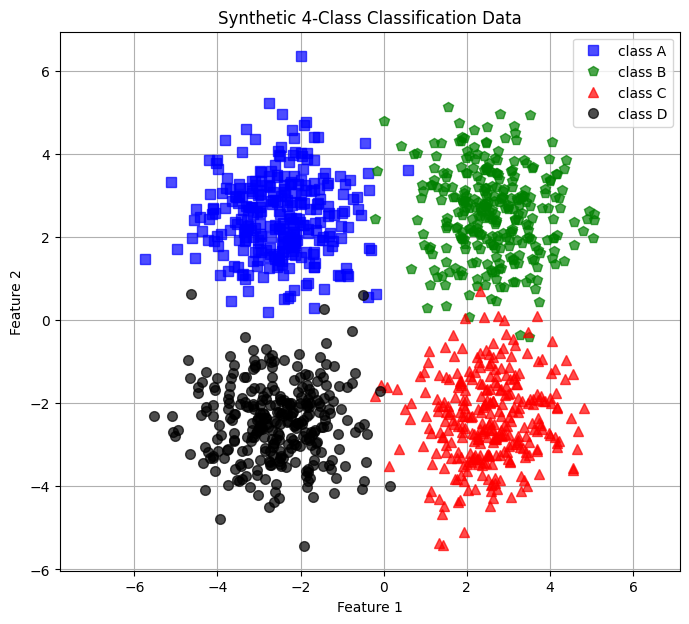


Starting MLP training on synthetic dataset...
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Ep

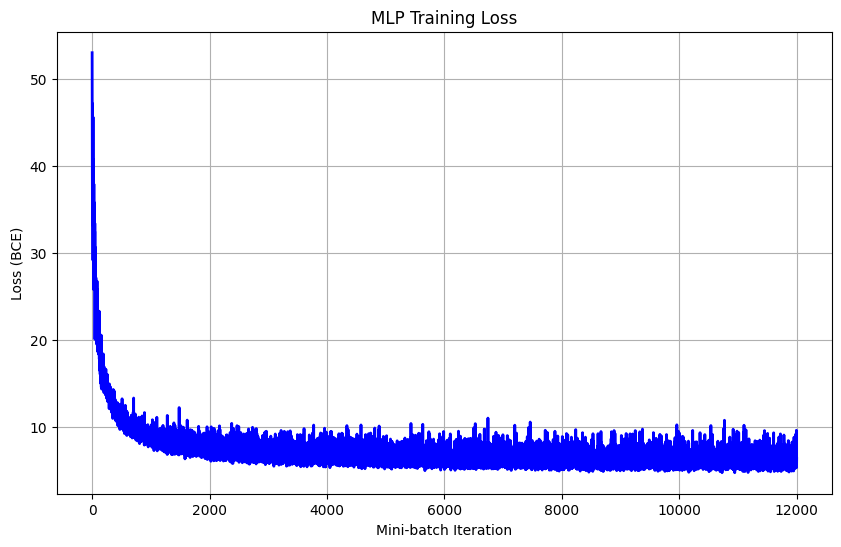


Confusion Matrix (Test Set):
[[298   1   0   1]
 [  2 295   3   0]
 [  0   3 296   1]
 [  3   0   0 297]]


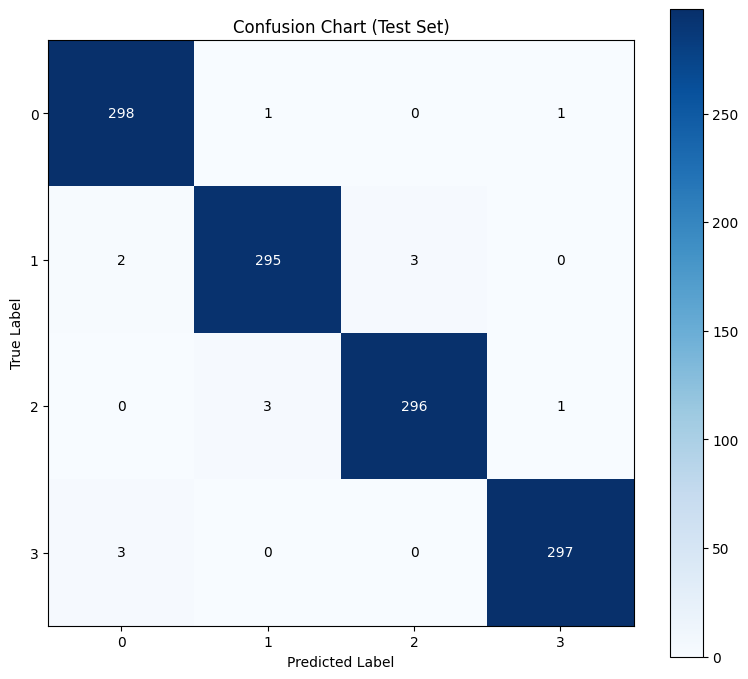

In [12]:
plt.close('all') # Close all matplotlib figures to ensure clean plots

# --- Parameters for Synthetic Data Generation ---
Nclasses = 4          # Number of classes for the synthetic dataset
Ninput = 2            # Number of input features (dimensions of X, i.e., 2D)
displacement = 2.5    # Spatial separation between the class clusters
NtrainPerClass = 300  # Number of training patterns per class
NtestPerClass = NtrainPerClass # Number of test patterns per class

# --- Generate Synthetic Data ---
print("Generating synthetic 4-class data...")
Xtrain, ytrain, Xtest, ytest = synth_gen(NtrainPerClass, NtestPerClass, displacement, Ninput, Nclasses)
print(f"Training data shape: X={Xtrain.shape}, y={ytrain.shape}")
print(f"Test data shape: X={Xtest.shape}, y={ytest.shape}")

# --- Display a Sample of Training Data ---
print("Displaying a sample of synthetic training data:")
synth_display(Xtrain, ytrain)

# --- Model Parameters for MLP ---
model = {
    'n_output': Nclasses,          # Number of output classes
    'n_features': Ninput,          # Number of input features
    'n_hidden': 25,                # Number of neurons in the hidden layer
    'l1': 0,                       # L1 regularization weight
    'l2': 0.1,                     # L2 regularization weight
    'epochs': 100,                 # Number of training epochs
    'eta': 0.001,                  # Initial learning rate
    'alpha': 0.001,                # Momentum coefficient
    'decrease_const': 0.00001,     # Constant for adaptive learning rate decay
    'minibatches': Xtrain.shape[0] // 10, # Number of mini-batches per epoch
}

# --- Train MLP ---
print("\nStarting MLP training on synthetic dataset...")
model_trained, W1_trained, W2_trained = MLP_BCESIG_train(Xtrain, ytrain, model)
print("MLP training complete.")

# --- Make Predictions ---
ytrain_pred = MLP_BCESIG_predict(Xtrain, W1_trained, W2_trained)
ytest_pred  = MLP_BCESIG_predict(Xtest,  W1_trained, W2_trained)

# --- Compute and Display Accuracy ---
acc_train = np.sum(ytrain == ytrain_pred) / Xtrain.shape[0]
print(f'\nTraining accuracy: {acc_train * 100:.2f}%')

acc_test = np.sum(ytest == ytest_pred) / Xtest.shape[0]
print(f'Test accuracy: {acc_test * 100:.2f}%')

# --- Plot Training Loss ---
plt.figure(figsize=(10, 6))
plt.plot(model_trained['cost_history'], color='blue', linewidth=2)
plt.title('MLP Training Loss')
plt.xlabel('Mini-batch Iteration')
plt.ylabel('Loss (BCE)')
plt.grid(True)
plt.show()

# --- Compute and Display Confusion Matrix ---
print("\nConfusion Matrix (Test Set):")
num_classes = model['n_output']
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

for i in range(len(ytest)):
    true_label = ytest[i]
    predicted_label = ytest_pred[i]
    confusion_matrix[true_label, predicted_label] += 1

print(confusion_matrix)

# --- Visualize Confusion Matrix (Confusion Chart) ---
plt.figure(figsize=(8, 7))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Chart (Test Set)')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, np.arange(num_classes))
plt.yticks(tick_marks, np.arange(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to the cells
thresh = confusion_matrix.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


# **6. Visualization of Learned Decision Surface**

This section visualizes the decision boundaries learned by the trained Multi-Layer Perceptron. For a 2D input space, this involves creating a dense grid of points, predicting the class for each point using the trained MLP, and then plotting these predicted classes as color regions. The original training data points are overlaid to show how they fall within these learned regions. This plot provides an intuitive understanding of how the MLP separates the different classes in the input feature space.


Visualizing the learned decision surface...


<ipython-input-14-af20fc24dc69>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap('tab10', Nclasses) # Get distinct colors from 'tab10' colormap


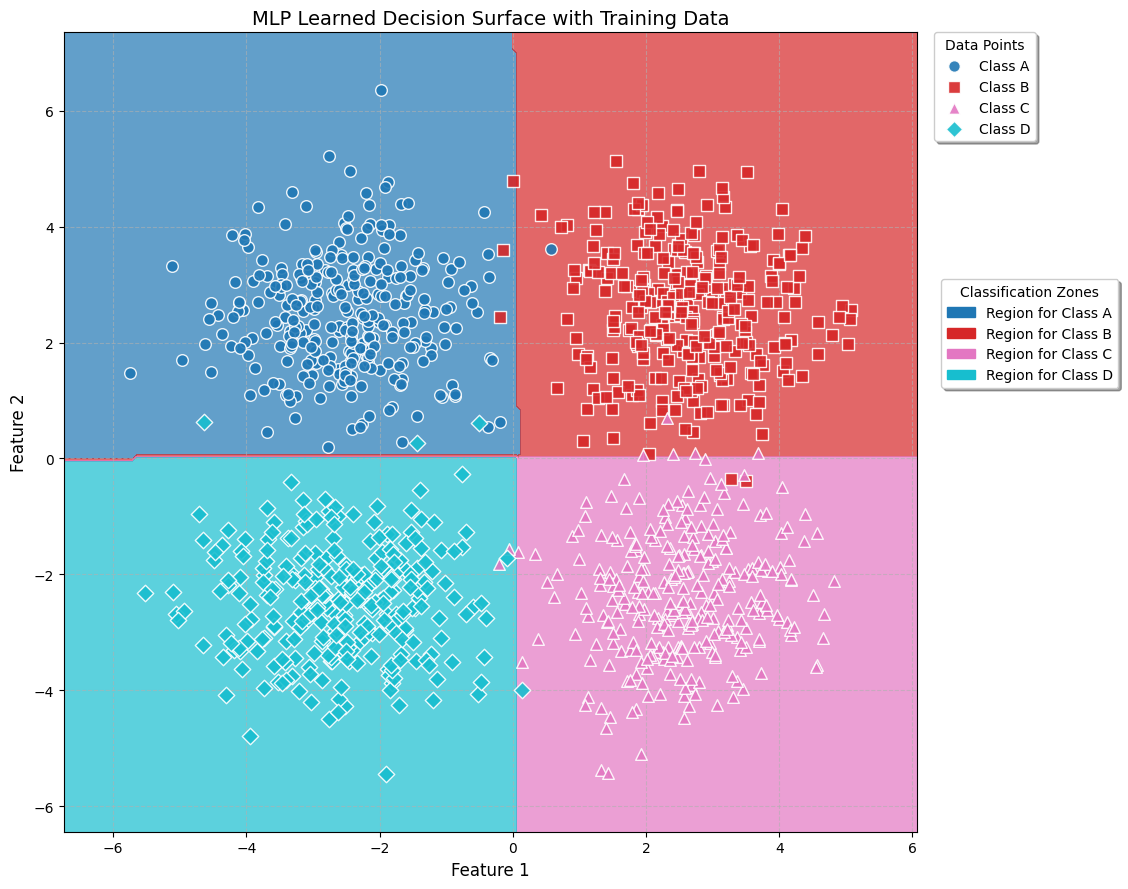

In [14]:
# --- Visualize Learned Decision Surface ---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Import needed for custom legend handles

# Assuming these variables are defined elsewhere in your code:
# Ninput: Number of input features
# Xtrain: Training data features
# Nclasses: Number of output classes
# MLP_BCESIG_predict: Function to predict class labels
# W1_trained, W2_trained: Trained weights of the MLP
# ytrain: Training data true labels

if Ninput == 2:  # Only applicable for 2D input features
    print("\nVisualizing the learned decision surface...")

    # Define a dense grid over the input feature space
    x_min, x_max = Xtrain[:, 0].min() - 1, Xtrain[:, 0].max() + 1
    y_min, y_max = Xtrain[:, 1].min() - 1, Xtrain[:, 1].max() + 1

    # Create a meshgrid for visualization
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Flatten the meshgrid points to pass through the MLP for prediction
    X_grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict classes for each point on the grid
    Z = MLP_BCESIG_predict(X_grid, W1_trained, W2_trained)
    Z = Z.reshape(xx.shape)

    # --- Define consistent colors and markers ---
    # These colors will be used for both scatter points and decision regions
    # Using a perceptually uniform colormap to get distinct colors
    # For Nclasses up to 4, these provide good distinction
    # For more classes, consider a different approach or colormap.
    base_colors = plt.cm.get_cmap('tab10', Nclasses) # Get distinct colors from 'tab10' colormap
    class_colors = [base_colors(i) for i in range(Nclasses)]
    class_markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'h', 'p', 'v'][:Nclasses] # Ensure enough markers
    class_labels = [f'Class {chr(65 + i)}' for i in range(Nclasses)]

    # Prepare the figure for plotting
    plt.figure(figsize=(12, 9))

    # Plot the decision regions using contourf
    # We create a ListedColormap from our class_colors to ensure a direct match
    from matplotlib.colors import ListedColormap
    cmap_decision_regions = ListedColormap(class_colors)

    plt.contourf(xx, yy, Z, levels=np.arange(Nclasses + 1) - 0.5,
                 cmap=cmap_decision_regions, alpha=0.7) # Slightly reduced alpha for overlay clarity

    # Overlay the original training data points
    for i in range(Nclasses):
        idx = (ytrain == i)
        plt.scatter(Xtrain[idx, 0], Xtrain[idx, 1], marker=class_markers[i],
                    color=class_colors[i], label=class_labels[i],
                    s=70, edgecolors='white', linewidth=1, alpha=0.9, zorder=2) # zorder to ensure points are on top

    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title('MLP Learned Decision Surface with Training Data', fontsize=14)

    # --- Create custom legend handles for decision regions ---
    # This creates colored patches that represent the classification zones
    region_legend_handles = []
    for i in range(Nclasses):
        patch = mpatches.Patch(color=class_colors[i], label=f'Region for {class_labels[i]}')
        region_legend_handles.append(patch)

    # Combine data point legend with region legend
    # The first legend displays the data points
    legend1 = plt.legend(title="Data Points", loc='upper left',
                         bbox_to_anchor=(1.02, 1), borderaxespad=0.,
                         fontsize=10, frameon=True, shadow=True)

    # The second legend displays the decision regions
    # We place it slightly below the first one
    legend2 = plt.legend(handles=region_legend_handles, title="Classification Zones",
                         loc='upper left', bbox_to_anchor=(1.02, 0.7),
                         fontsize=10, frameon=True, shadow=True)

    plt.gca().add_artist(legend1) # Add the first legend back to the plot

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make space for the legends outside the plot area
    plt.show()

else:
    print("\nDecision surface visualization is only supported for 2D input (Ninput = 2).")